In [1]:
import numpy as np
import pandas as pd 

In [4]:
import os
print(os.listdir("../input"))

['label_names_2018.csv', 'video', '.DS_Store', 'vocabulary.csv', 'frame', 'sample_submission.csv']


In [5]:
print(os.listdir("../input/frame"))
print(os.listdir("../input/video"))

['train01.tfrecord', 'train00.tfrecord']
['train01.tfrecord', 'train00.tfrecord']


In [6]:
import tensorflow as tf
import numpy as np
from IPython.display import YouTubeVideo

video_lvl_record = "../input/video/train00.tfrecord"
frame_lvl_record = "../input/frame/train00.tfrecord"

In [7]:
vid_ids = []
labels = []
mean_rgb = []
mean_audio = []

for example in tf.python_io.tf_record_iterator(video_lvl_record):
    tf_example = tf.train.Example.FromString(example)

    vid_ids.append(tf_example.features.feature['id'].bytes_list.value[0].decode(encoding='UTF-8'))
    labels.append(tf_example.features.feature['labels'].int64_list.value)
    mean_rgb.append(tf_example.features.feature['mean_rgb'].float_list.value)
    mean_audio.append(tf_example.features.feature['mean_audio'].float_list.value)

In [8]:
print('Number of videos in this tfrecord: ',len(mean_rgb))
print('Picking a youtube video id:',vid_ids[13])
print('First 20 features of a youtube video (',vid_ids[13],'):')
print(mean_rgb[13][:20])

Number of videos in this tfrecord:  1015
Picking a youtube video id: 1r00
First 20 features of a youtube video ( 1r00 ):
[-0.13220332562923431, 0.4008486270904541, -0.38416850566864014, 0.5839489698410034, -0.18826593458652496, -0.6205881237983704, -0.4101247191429138, -0.5345597863197327, -0.31811732053756714, 0.2005145102739334, -0.37854114174842834, 0.3848106563091278, 0.1220831423997879, 0.4372154772281647, -0.2255472093820572, 0.3350788354873657, -0.31312304735183716, -0.4648508131504059, -0.3584936559200287, 0.3542822003364563]


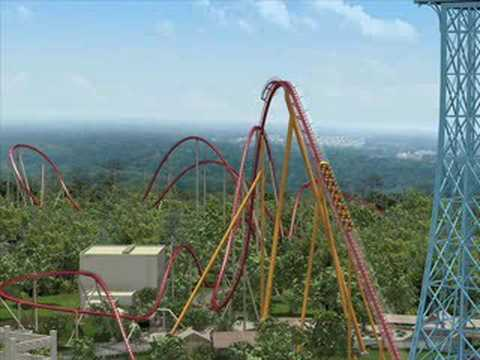

In [9]:
YouTubeVideo('-QM5ooctj0w')

In [10]:
#pay attention to how to extract feature, data description https://research.google.com/youtube8m/download.html
feat_rgb = []
feat_audio = []

for example in tf.python_io.tf_record_iterator(frame_lvl_record):        
    tf_seq_example = tf.train.SequenceExample.FromString(example)
    n_frames = len(tf_seq_example.feature_lists.feature_list['audio'].feature)
    sess = tf.InteractiveSession()
    rgb_frame = []
    audio_frame = []
    # iterate through frames
    for i in range(n_frames):
        rgb_frame.append(tf.cast(tf.decode_raw(
                tf_seq_example.feature_lists.feature_list['rgb'].feature[i].bytes_list.value[0],tf.uint8)
                       ,tf.float32).eval())
        audio_frame.append(tf.cast(tf.decode_raw(
                tf_seq_example.feature_lists.feature_list['audio'].feature[i].bytes_list.value[0],tf.uint8)
                       ,tf.float32).eval())
        
        
    sess.close()
    feat_rgb.append(rgb_frame)
    feat_audio.append(audio_frame)
    break

In [11]:
print('The first video has %d frames' %len(feat_rgb[0]))

The first video has 234 frames


In [13]:
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
import numpy as np

In [14]:
labels_2018 = pd.read_csv('../input/label_names_2018.csv')
print("we have {} unique labels in the dataset".format(len(labels_2018['label_name'].unique())))

we have 3807 unique labels in the dataset


In [15]:
n=10
from collections import Counter
label_mapping = pd.read_csv('../input/label_names_2018.csv',header=0,index_col=0,squeeze=True).T.to_dict()

top_n = Counter([item for sublist in labels for item in sublist]).most_common(n)
top_n_labels = [int(i[0]) for i in top_n]
top_n_label_names = [label_mapping[x] for x in top_n_labels]
top_n_label_names

['Game',
 'Vehicle',
 'Video game',
 'Concert',
 'Car',
 'Dance',
 'Musician',
 'Animation',
 'Food',
 'Musical ensemble']

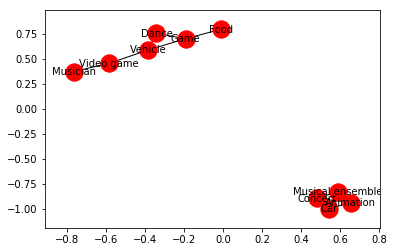

In [16]:
import networkx as nx
from itertools import combinations

G=nx.Graph()

G.clear()
for list_of_nodes in labels:
    filtered_nodes = set(list_of_nodes).intersection(set(top_n_labels))  
    for node1,node2 in list(combinations(filtered_nodes,2)): 
        node1_name = label_mapping[node1]
        node2_name = label_mapping[node2]
        G.add_node(node1_name)
        G.add_node(node2_name)
        G.add_edge(node1_name, node2_name)

nx.draw_networkx(G,font_size="10")

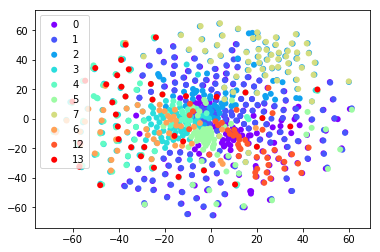

In [17]:
#And a t-SNE plot on the data...
colors = plt.cm.rainbow(np.linspace(0, 1, n))
mean_rgb_top_n = []
labels_for_tsne = []
# filtering mean_rgb so it only contains top n labels
for idx, list_of_nodes in enumerate(labels):
    for node in list_of_nodes:
        if node in top_n_labels:
            mean_rgb_top_n.append(mean_rgb[idx])
            labels_for_tsne.append(node)


X_embedded = TSNE(n_components=2, random_state=0).fit_transform(mean_rgb_top_n) 


fig = plt.figure()
ax = fig.add_subplot(111)

handles = []
for indx, color in enumerate(colors):
    this_label = top_n_labels[indx]
    X_embedded_filtered = X_embedded[np.array([x==this_label for x in labels_for_tsne])]
    handles.append(ax.scatter(X_embedded_filtered[:, 0], X_embedded_filtered[:, 1], c=color, marker="o",edgecolor='none'))

ax.legend(handles, top_n_labels)

plt.show()